In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [85]:
from talib import EMA, RSI, OBV

In [86]:
from sklearn.model_selection import train_test_split # for the initial split to a train set and a untouched test set 
from sklearn.model_selection import TimeSeriesSplit # for roll forward cross vallidation
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [87]:
import graphviz

In [88]:
import GetOldTweets3 as got #get historic tweets

In [89]:
from textblob import TextBlob #Sentiment discovery
#python -m textblob.download_corpora

In [90]:
import re

## Read the downloaded forex file

In [91]:
df=pd.read_csv("forex.csv", index_col=0, parse_dates=True)

In [92]:
df.head()


,open,high,low,close,volume
date,,,,,
2011-03-29,1.4086,1.4148,1.4047,1.4113,64044
2011-03-30,1.4113,1.4146,1.4052,1.4126,70281
2011-03-31,1.4127,1.4232,1.4116,1.4174,73492
2011-04-01,1.4173,1.4245,1.4061,1.4234,70943
2011-04-04,1.4231,1.4268,1.4192,1.4218,61094


In [93]:
df.columns=[["open","high","low", "close", "volume"]]

In [94]:
df=df.loc['2016-12-31':'2018-12-31']

In [95]:
df=df.dropna()
df.head()
df.shape

(524, 5)

In [96]:
type(df)

pandas.core.frame.DataFrame

## Adding the indicators from talib library

In [97]:
ema_short_period=10
ema_long_period=30
rsi_period=14

In [98]:
df["ema_short"]=df["close"].apply(lambda row: EMA(row,timeperiod=ema_short_period))

In [99]:
df["ema_long"]=df["close"].apply(lambda row: EMA(row,timeperiod=ema_long_period))

In [100]:
df["rsi"]=df["close"].apply(lambda row: RSI(row,timeperiod=rsi_period))

In [101]:
df['obv'] = df.apply(lambda row: OBV(row['close'], row['volume']), axis=1)

In [102]:
df.tail()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv
date,,,,,,,,,
2018-12-24,1.13731,1.14377,1.13599,1.14211,64506,1.137809,1.137390,54.617427,64506.0
2018-12-26,1.14047,1.14134,1.13419,1.13499,49809,1.137296,1.137235,48.210375,49809.0
2018-12-27,1.13503,1.14533,1.13503,1.14275,119487,1.138288,1.137591,54.478149,119487.0
2018-12-28,1.14244,1.14720,1.14244,1.14400,94201,1.139326,1.138004,55.414201,94201.0
2018-12-31,1.14330,1.14654,1.14208,1.14499,54782,1.140356,1.138455,56.182687,54782.0


In [103]:
df["close_nextday"]=df.close.shift(-1) # used as target prediction

In [104]:
df.dropna(inplace=True)

In [105]:
df.head()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv,close_nextday
date,,,,,,,,,,
2017-02-10,1.06542,1.06669,1.06070,1.06392,75257,1.069652,1.065253,50.407571,75257.0,1.05965
2017-02-13,1.06275,1.06576,1.05912,1.05965,67638,1.067833,1.064892,46.739383,67638.0,1.05761
2017-02-14,1.05968,1.06326,1.05600,1.05761,72367,1.065975,1.064422,45.052587,72367.0,1.05985
2017-02-15,1.05761,1.06084,1.05206,1.05985,75934,1.064861,1.064127,47.301538,75934.0,1.06727
2017-02-16,1.05983,1.06786,1.05902,1.06727,75581,1.065299,1.064330,54.015581,75581.0,1.06093


## Getting tweets (run once, don't run again - please skip to reading tweets.csv file)

In [48]:
max_tweets=5000
start_date='2016-12-31'
end_date='2018-12-31'
query='EURUSD'

In [49]:
def tweet_hist(query, start_date, end_date, max_tweets):
    tweet_criteria = got.manager.TweetCriteria().setQuerySearch(query).setSince(start_date).setUntil(end_date).setMaxTweets(max_tweets).setTopTweets(True)
    tweets = got.manager.TweetManager.getTweets(tweet_criteria)

    for i in range(len(tweets)):
        d = {'date':tweets[i].date, 'tweet_id':tweets[i].id, 'tweet_username':tweets[i].username,'tweet_text':tweets[i].text}
        if i == 0:
            df = pd.DataFrame.from_dict(d,orient='index').T
            df.index = df['date']
            df = df.drop('date', axis=1)
        else:
            df2 = pd.DataFrame.from_dict(d,orient='index').T
            df2.index = df2['date']
            df2 = df2.drop('date', axis=1)
            df = df.append(df2)
    
    return df

In [50]:
tweets_df=tweet_hist(query, start_date, end_date, max_tweets)

In [52]:
tweets_df.head(20)

,tweet_id,tweet_username,tweet_text
date,,,
2018-12-30 21:36:55+00:00,1079491546972545025,IGSquawk,"Hi all, our FX markets are now open for tradin..."
2018-12-30 19:39:18+00:00,1079461947911876608,HenrikZeberg,#EURUSD topped early 2018 and has dropped to a...
2018-12-30 19:08:10+00:00,1079454111236571138,FXstreetNews,Italian parliament lowers planned 2019 budget ...
2018-12-30 15:43:24+00:00,1079402583826092032,GFA_Trader,My most memorable moment this year was achievi...
2018-12-30 11:47:07+00:00,1079343119756419072,Marc_Hav,$EURUSD Hourly pic.twitter.com/EyMH2fLZ2r
2018-12-30 08:46:15+00:00,1079297602007511047,aleksfx,$EURUSD monthly bounce of the long-term uptren...
2018-12-29 22:50:03+00:00,1079147562198843392,hugibluegold,Sell #EURUSD #FOREX TP: 1.14101 SL: 1.14471 En...
2018-12-29 18:17:09+00:00,1079078887177576448,joefriday_714,Updated $DXY and $EURUSD Mthly Charts... still...
2018-12-29 16:17:11+00:00,1079048695734288384,david_pickworth,Trader predictions for 2019? 1. loss of US$str...


In [53]:
tweets_df.shape

(5000, 3)

In [54]:
tweets_df.to_csv('tweets.csv')

## Reading tweets

In [106]:
tweets_df1=pd.read_csv("tweets.csv", index_col='date', parse_dates=True)

In [107]:
tweets_df1.shape

(5000, 3)

## Clearing tweets and getting sentiment

In [108]:
tweets_df1['tweet_text_clean']=tweets_df1['tweet_text'].apply(lambda row: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", row).split()))

In [109]:
tweets_df1.head()

,tweet_id,tweet_username,tweet_text,tweet_text_clean
date,,,,
2018-12-30 21:36:55+00:00,1079491546972545025,IGSquawk,"Hi all, our FX markets are now open for tradin...",Hi all our FX markets are now open for trading...
2018-12-30 19:39:18+00:00,1079461947911876608,HenrikZeberg,#EURUSD topped early 2018 and has dropped to a...,EURUSD topped early 2018 and has dropped to a ...
2018-12-30 19:08:10+00:00,1079454111236571138,FXstreetNews,Italian parliament lowers planned 2019 budget ...,Italian parliament lowers planned 2019 budget ...
2018-12-30 15:43:24+00:00,1079402583826092032,GFA_Trader,My most memorable moment this year was achievi...,My most memorable moment this year was achievi...
2018-12-30 11:47:07+00:00,1079343119756419072,Marc_Hav,$EURUSD Hourly pic.twitter.com/EyMH2fLZ2r,EURUSD Hourly pic twitter com EyMH2fLZ2r


In [110]:
tweets_df1['tweet_sentiment']=tweets_df1['tweet_text_clean'].apply(
            lambda row: 1 if TextBlob(row).sentiment.polarity>0 else(0 if TextBlob(row).sentiment.polarity==0 else -1))

In [111]:
tweets_df1.head()

,tweet_id,tweet_username,tweet_text,tweet_text_clean,tweet_sentiment
date,,,,,
2018-12-30 21:36:55+00:00,1079491546972545025,IGSquawk,"Hi all, our FX markets are now open for tradin...",Hi all our FX markets are now open for trading...,0
2018-12-30 19:39:18+00:00,1079461947911876608,HenrikZeberg,#EURUSD topped early 2018 and has dropped to a...,EURUSD topped early 2018 and has dropped to a ...,1
2018-12-30 19:08:10+00:00,1079454111236571138,FXstreetNews,Italian parliament lowers planned 2019 budget ...,Italian parliament lowers planned 2019 budget ...,0
2018-12-30 15:43:24+00:00,1079402583826092032,GFA_Trader,My most memorable moment this year was achievi...,My most memorable moment this year was achievi...,1
2018-12-30 11:47:07+00:00,1079343119756419072,Marc_Hav,$EURUSD Hourly pic.twitter.com/EyMH2fLZ2r,EURUSD Hourly pic twitter com EyMH2fLZ2r,0


In [112]:
tweets_indicator_df=tweets_df1.resample('D').tweet_sentiment.mean() #we need only index and mean polarity for each day

In [113]:
tweets_indicator_df.head()

date
2018-03-16 00:00:00+00:00    0.100000
2018-03-17 00:00:00+00:00    0.200000
2018-03-18 00:00:00+00:00    0.500000
2018-03-19 00:00:00+00:00    0.264706
2018-03-20 00:00:00+00:00    0.047619
Freq: D, Name: tweet_sentiment, dtype: float64

## Getting rid of  the time part of index 

In [114]:
tweets_indicator_df=tweets_indicator_df.tz_localize(None)

In [115]:
tweets_indicator_df.head()

date
2018-03-16    0.100000
2018-03-17    0.200000
2018-03-18    0.500000
2018-03-19    0.264706
2018-03-20    0.047619
Freq: D, Name: tweet_sentiment, dtype: float64

In [116]:
tweets_indicator_df.fillna(method='ffill')

date
2018-03-16    0.100000
2018-03-17    0.200000
2018-03-18    0.500000
2018-03-19    0.264706
2018-03-20    0.047619
2018-03-21    0.542857
2018-03-22    0.666667
2018-03-23    0.529412
2018-03-24    0.000000
2018-03-25   -0.166667
2018-03-26    0.347826
2018-03-27    0.344828
2018-03-28    0.230769
2018-03-29    0.222222
2018-03-30    0.800000
2018-03-31    0.800000
2018-04-01    0.300000
2018-04-02    0.136364
2018-04-03    0.000000
2018-04-04    0.157895
2018-04-05   -0.058824
2018-04-06    0.190476
2018-04-07    1.000000
2018-04-08    0.333333
2018-04-09    0.150000
2018-04-10    0.230769
2018-04-11    0.142857
2018-04-12    0.464286
2018-04-13    0.500000
2018-04-14    0.333333
                ...   
2018-12-01    0.571429
2018-12-02    0.250000
2018-12-03    0.318182
2018-12-04    0.392857
2018-12-05    0.090909
2018-12-06    0.444444
2018-12-07    0.411765
2018-12-08   -0.142857
2018-12-09    0.400000
2018-12-10    0.034483
2018-12-11    0.370370
2018-12-12    0.173913
2018-1

In [117]:
type(tweets_indicator_df)

pandas.core.series.Series

## Inner Join of df with tweets_indicator_df

In [118]:
df1=df.join(tweets_indicator_df, how="inner")

In [119]:
df1.head()

,"(open,)","(high,)","(low,)","(close,)","(volume,)","(ema_short,)","(ema_long,)","(rsi,)","(obv,)","(close_nextday,)",tweet_sentiment
date,,,,,,,,,,,
2018-03-16,1.23035,1.23353,1.22592,1.22866,51748,1.232660,1.231182,47.220404,51748.0,1.22872,0.100000
2018-03-18,1.22820,1.22906,1.22810,1.22872,601,1.231944,1.231023,47.277795,601.0,1.23333,0.500000
2018-03-19,1.22873,1.23578,1.22572,1.23333,57133,1.232196,1.231172,51.629781,57133.0,1.22426,0.264706
2018-03-20,1.23334,1.23539,1.22390,1.22426,55554,1.230753,1.230726,43.944051,55554.0,1.23377,0.047619
2018-03-21,1.22427,1.23489,1.22409,1.23377,64915,1.231302,1.230923,52.010605,64915.0,1.23049,0.542857


In [120]:
df1.shape

(207, 11)

In [121]:
df1.columns=['open', 'high', 'low', 'close', 'volume', 'ema_short', 'ema_long', 'rsi','obv', 'close_nextday','tweet_sentiment']

In [122]:
df1.head()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv,close_nextday,tweet_sentiment
date,,,,,,,,,,,
2018-03-16,1.23035,1.23353,1.22592,1.22866,51748,1.232660,1.231182,47.220404,51748.0,1.22872,0.100000
2018-03-18,1.22820,1.22906,1.22810,1.22872,601,1.231944,1.231023,47.277795,601.0,1.23333,0.500000
2018-03-19,1.22873,1.23578,1.22572,1.23333,57133,1.232196,1.231172,51.629781,57133.0,1.22426,0.264706
2018-03-20,1.23334,1.23539,1.22390,1.22426,55554,1.230753,1.230726,43.944051,55554.0,1.23377,0.047619
2018-03-21,1.22427,1.23489,1.22409,1.23377,64915,1.231302,1.230923,52.010605,64915.0,1.23049,0.542857


## Choosing the Predictors

In [123]:
predictors=['open', 'high', 'low', 'close', 'volume', 'ema_short', 'ema_long', 'rsi', 'obv', 'tweet_sentiment']

In [124]:
prediction=['close_nextday']

## Initial split to a train set and a untouched test set 

In [125]:
x_train_df, x_test_df, y_train_df, y_test_df=train_test_split(df1[predictors], df1[prediction], test_size=0.3)

In [126]:
x_train_df.head()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv,tweet_sentiment
date,,,,,,,,,,
2018-04-20,1.23435,1.23520,1.22487,1.22864,49364,1.233394,1.232523,45.443577,49364.0,0.217391
2018-05-02,1.19910,1.20308,1.19371,1.19493,73838,1.211947,1.222887,25.805572,73838.0,0.166667
2018-11-02,1.14010,1.14550,1.13713,1.13857,91261,1.139486,1.147478,41.556793,91261.0,0.409091
2018-10-08,1.15204,1.15289,1.14592,1.14898,59054,1.156301,1.160658,38.412216,59054.0,0.363636
2018-06-22,1.15977,1.16742,1.15976,1.16550,66249,1.164258,1.173700,44.472819,66249.0,0.368421


In [127]:
y_train_df.head()

,close_nextday
date,
2018-04-20,1.22075
2018-05-02,1.19870
2018-11-02,1.14058
2018-10-08,1.14882
2018-06-22,1.17019


In [128]:
x_test_df.head()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv,tweet_sentiment
date,,,,,,,,,,
2018-06-18,1.15865,1.16234,1.15646,1.16215,43413,1.168314,1.177721,39.248667,43413.0,0.230769
2018-07-16,1.16891,1.17246,1.16749,1.17101,46907,1.168948,1.169977,51.738659,46907.0,0.384615
2018-04-09,1.22840,1.23295,1.22594,1.23196,55668,1.229796,1.230870,50.946766,55668.0,0.150000
2018-10-12,1.15924,1.16097,1.15338,1.15571,81167,1.155326,1.159123,46.803970,81167.0,-0.040000
2018-07-19,1.16372,1.16778,1.15741,1.16402,70174,1.166911,1.168989,45.137415,70174.0,0.238095


In [129]:
y_test_df.head()

,close_nextday
date,
2018-06-18,1.15874
2018-07-16,1.16595
2018-04-09,1.23549
2018-10-12,1.15775
2018-07-19,1.17197


## x and y values from the train set

In [130]:
x=x_train_df.values # selected features

In [131]:
y=y_train_df.values.ravel()# labels

In [132]:
y=np.round(y, 4)

In [133]:
y

array([1.2208, 1.1987, 1.1406, 1.1488, 1.1702, 1.1604, 1.2338, 1.2368,
       1.1783, 1.1401, 1.14  , 1.1313, 1.1769, 1.1606, 1.1645, 1.1628,
       1.1553, 1.1655, 1.1572, 1.1544, 1.1407, 1.1655, 1.1704, 1.1602,
       1.1746, 1.164 , 1.1677, 1.1368, 1.1285, 1.1765, 1.1565, 1.1565,
       1.2279, 1.1622, 1.1697, 1.1444, 1.1512, 1.1408, 1.1655, 1.1316,
       1.1649, 1.1797, 1.2333, 1.1669, 1.179 , 1.1352, 1.1863, 1.2316,
       1.2401, 1.1671, 1.1341, 1.1346, 1.2286, 1.1389, 1.1518, 1.1343,
       1.1569, 1.1716, 1.1691, 1.2299, 1.1836, 1.1425, 1.2287, 1.1655,
       1.1371, 1.1372, 1.1591, 1.1396, 1.1602, 1.1775, 1.1421, 1.169 ,
       1.164 , 1.2102, 1.1753, 1.1658, 1.1567, 1.1609, 1.1681, 1.1663,
       1.1397, 1.1344, 1.1961, 1.1372, 1.1689, 1.1536, 1.1727, 1.1768,
       1.1741, 1.1326, 1.1366, 1.2373, 1.1557, 1.1354, 1.2353, 1.1362,
       1.144 , 1.1358, 1.1315, 1.148 , 1.1718, 1.1381, 1.179 , 1.171 ,
       1.1468, 1.2378, 1.1938, 1.1552, 1.1514, 1.1331, 1.2344, 1.1659,
      

In [134]:
sc=StandardScaler(copy=True, with_mean=True, with_std=True)

In [135]:
x_normal=np.round(sc.fit_transform(x), 4)

In [136]:
print(x_normal)

[[ 2.1451  2.0563  1.9903 ...  0.05   -0.9318 -0.3098]
 [ 0.9922  0.9923  0.9558 ... -2.148   0.3646 -0.5814]
 [-0.9373 -0.9149 -0.9226 ... -0.385   1.2876  0.7166]
 ...
 [-1.2202 -1.1421 -1.1125 ...  0.5555  1.2853 -0.5426]
 [-0.0085 -0.0123 -0.1414 ... -2.4953 -0.6126 -1.206 ]
 [-0.0579 -0.1388 -0.2171 ...  0.6806  1.2013  1.2033]]


## Roll forward cross validation

In [137]:
tss = TimeSeriesSplit(n_splits=5)

In [138]:
print(tss)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [139]:
model_score = []

## Creating the Random Forest model

In [140]:
model=RandomForestRegressor(n_estimators=20, max_features="sqrt", max_depth=10,random_state=1)

## Cross validation and metrics

In [141]:
for train_index, test_index in tss.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model=model.fit(x_train, y_train)
    y_pred=model.predict(x_test)
    model_score.append(metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average' ))   
    print('Model score= ', model_score)
    print('Importance of predictors: ', model.feature_importances_)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Model score=  [0.9372518575695429]
Importance of predictors:  [0.16439119 0.06379078 0.2081667  0.22185977 0.01769436 0.09997512
 0.19064979 0.01945969 0.00602577 0.00798682]
Mean Absolute Error: 0.005985906746031768
Mean Squared Error: 5.0860897933519725e-05
Root Mean Squared Error: 0.007131682685980898
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Model score=  [0.9372518575695429, 0.9738157416178475]
Importance of predictors:  [0.14718468 0.1175263  0.21843925 0.22720527 0.00702581 0.13310609
 0.12683621 0.01300081 0.0064768  0.0031988 ]
Mean Absolute Error: 0.0038327847222222413
Mean Squared Error: 2.7822574244213e-05
Root Mean Squared Err

## Checking for erroneous values

In [142]:
np.isinf(y_test).sum(),np.isnan(y_test).sum()

(0, 0)

In [143]:
y_test=pd.Series(y_test)
(y_test[np.isnan(y_test)])

Series([], dtype: float64)

## Quick plot of real values compared to predicted values

In [144]:
len(y_test)

24

In [145]:
points=range(y_test.shape[0])

In [146]:
print(points)

range(0, 24)


In [147]:
print(y_test.shape[0])

24


In [148]:
%matplotlib inline

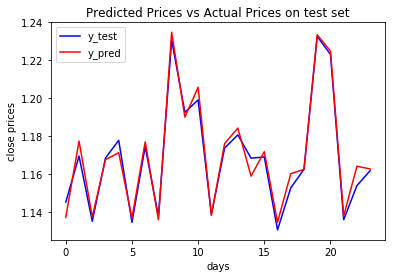

In [149]:
plt.plot(points, y_test, color='blue', label='y_test')
plt.plot(points, y_pred, color='red', label='y_pred')
plt.ylabel('close prices')
plt.xlabel('days')
plt.title('Predicted Prices vs Actual Prices on test set')
plt.legend(loc='upper left')

In [150]:
plt.show()

## Predict values using the x_test_df set which is untouched

In [151]:
x_test_df['price_prediction'] = model.predict(x_test_df.loc[:,predictors])

## Creating the signal

In [152]:
x_test_df['model_signal'] = np.where(x_test_df.price_prediction>x_test_df.close, 1, -1)

## Compute the return and strategy return

In [153]:
def compute_ret(df): 
    # ret is daily returns
    df['ret'] = df.close.shift(-1).pct_change()
    df['cum_ret'] = np.cumsum(df.ret)
    df['strategy_ret'] = df.ret * df.model_signal.shift(1)
    df['cum_strategy_ret'] = np.cumsum(df.strategy_ret)
    return df

In [154]:
df2=compute_ret(x_test_df)

In [155]:
df2.head()

,open,high,low,close,volume,ema_short,ema_long,rsi,obv,tweet_sentiment,price_prediction,model_signal,ret,cum_ret,strategy_ret,cum_strategy_ret
date,,,,,,,,,,,,,,,,
2018-06-18,1.15865,1.16234,1.15646,1.16215,43413,1.168314,1.177721,39.248667,43413.0,0.230769,1.162315,1,NaN,NaN,NaN,NaN
2018-07-16,1.16891,1.17246,1.16749,1.17101,46907,1.168948,1.169977,51.738659,46907.0,0.384615,1.168591,-1,0.052049,0.052049,0.052049,0.052049
2018-04-09,1.22840,1.23295,1.22594,1.23196,55668,1.229796,1.230870,50.946766,55668.0,0.150000,1.232130,1,-0.061893,-0.009844,0.061893,0.113942
2018-10-12,1.15924,1.16097,1.15338,1.15571,81167,1.155326,1.159123,46.803970,81167.0,-0.040000,1.157911,1,0.007190,-0.002654,0.007190,0.121133
2018-07-19,1.16372,1.16778,1.15741,1.16402,70174,1.166911,1.168989,45.137415,70174.0,0.238095,1.166005,1,0.054698,0.052045,0.054698,0.175831


## Plot the return of benchmark and strategy

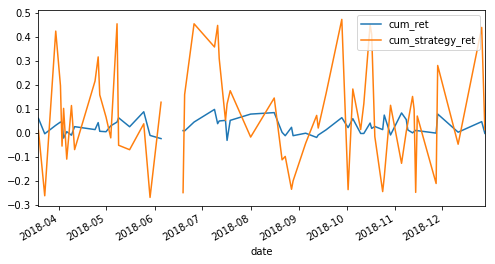

In [156]:
df2['cum_ret'].plot(figsize=(8,4))
df2['cum_strategy_ret'].plot(figsize=(8,4))
plt.legend(loc='upper right')
plt.show()

In [157]:
def sharpe(df):    
    sharpe_ratio = df.strategy_ret.mean()/df.strategy_ret.std()*np.sqrt(252)
    return sharpe_ratio

In [158]:
print(sharpe(df2))

2.9069317769870078


## Quick plot of real values compared to predicted values on untouched set

In [159]:
%matplotlib inline

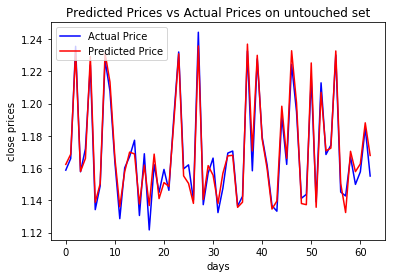

In [160]:
plt.plot(range(len(y_test_df['close_nextday'])), y_test_df['close_nextday'], color='blue', label='Actual Price')
plt.plot(range(len(y_test_df['close_nextday'])), x_test_df['price_prediction'], color='red', label='Predicted Price')
plt.ylabel('close prices')
plt.xlabel('days')
plt.title('Predicted Prices vs Actual Prices on untouched set')
plt.legend(loc='upper left')

In [161]:
## Visualizing a tree of the model

In [162]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

In [163]:
for tree_in_forest in model.estimators_:
    dot=tree.export_graphviz(tree_in_forest,
                feature_names=predictors,
                filled=True,
                rounded=True)

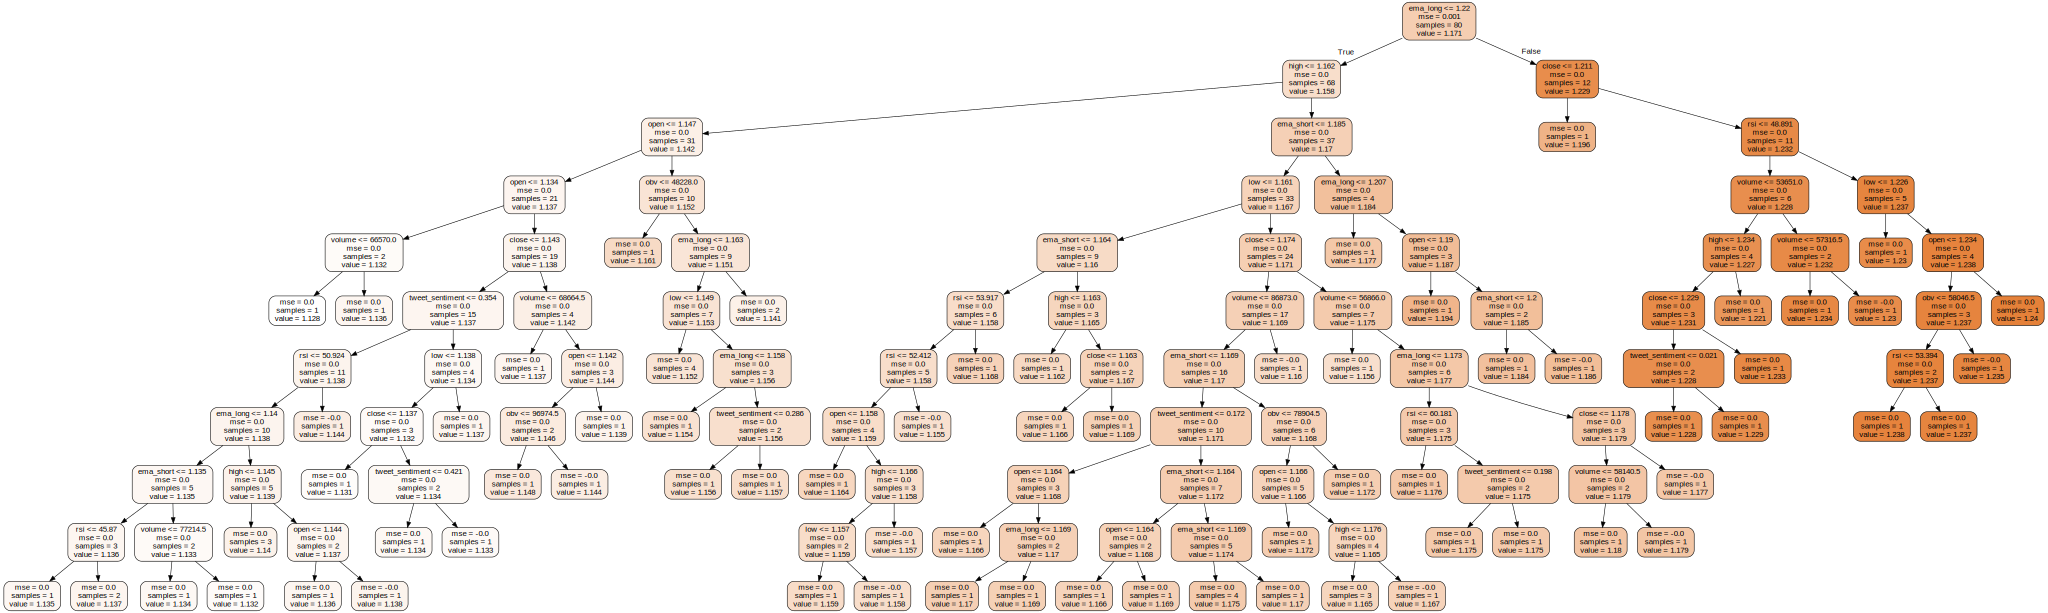

In [164]:
graphviz.Source(dot)

In [165]:
graphviz.Source(dot).view()

'Source.gv.pdf'